### Import required libraries

In [4]:
import numpy as np
import pandas as pd 
import os
import gc
import sklearn.model_selection
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

## suppress warnings
import warnings
warnings.filterwarnings("ignore")

### Read in Stata File

In [5]:
dta_path = "/export/storage_cpoliqui/data/wages2008.dta"
data = pd.read_stata(dta_path, convert_categoricals = False)

In [6]:
## rename all variables
headers = ["firm_id", "establishment_id", "year", "emp_present_12_31", "worker_id",
           "avg_month_wage_in_miniwage", "contract_salary_rea", "salary_type", "weekly_hrs", "hr_salary",
           "occupation_code", "reason_leave", "how_worker_entered", "date_enter", "date_left",
           "employment_type", "tenure_in_month", "female", "education_level", "nationality",
           "race", "age", "municipality", "microregion", "corp_form", "industry_cnae"]

data.columns = headers
data.head(10)

,firm_id,establishment_id,year,emp_present_12_31,worker_id,avg_month_wage_in_miniwage,contract_salary_rea,salary_type,weekly_hrs,hr_salary,...,tenure_in_month,female,education_level,nationality,race,age,municipality,microregion,corp_form,industry_cnae
0,4862437.0,4.862437e+12,2008,0,85202585,1.09,437.50,1,44,2.294598,...,49.000000,0,5.0,10,8.0,27,330470,33002,2135,810099
1,4862437.0,4.862437e+12,2008,0,24246094,1.11,437.50,1,44,2.294598,...,36.299999,0,5.0,10,2.0,40,330470,33002,2135,810099
2,4862437.0,4.862437e+12,2008,1,24607237,1.09,437.50,1,44,2.294598,...,52.900002,0,3.0,10,2.0,46,330470,33002,2135,810099
3,4862437.0,4.862437e+12,2008,1,24607236,1.12,437.50,1,44,2.294598,...,49.900002,0,5.0,10,8.0,49,330470,33002,2135,810099
4,4862393.0,4.862393e+12,2008,1,103906928,1.11,471.00,1,44,2.470299,...,6.300000,0,5.0,10,4.0,25,330455,33018,2062,4679699
5,4862393.0,4.862393e+12,2008,0,51289110,1.11,450.00,1,44,2.360158,...,5.900000,0,7.0,10,2.0,19,330455,33018,2062,4679699
6,4862393.0,4.862393e+12,2008,1,24607228,1.80,800.00,1,44,4.195837,...,9.400000,0,5.0,10,2.0,25,330455,33018,2062,4679699
7,4862393.0,4.862393e+12,2008,1,24607225,1.68,700.00,1,44,3.671357,...,5.900000,0,4.0,10,2.0,39,330455,33018,2062,4679699
8,4862393.0,4.862393e+12,2008,0,108744502,2.71,999.99,1,44,5.244743,...,1.100000,0,9.0,10,4.0,47,330455,33018,2062,4679699
9,4862393.0,4.862393e+12,2008,1,25176680,2.02,923.81,1,44,4.845195,...,28.900000,0,7.0,10,4.0,40,330455,33018,2062,4679699


### Process Whole Data

In [7]:
## based on salary types, tranform contract salary into hourly salary
def transform_sal(sal_type, weekly_hrs, contract_salary_rea):
    
    # 4.333 : monthly factor            sal_type = 1
    # 2.1667 : biweekly factor          sal_type = 2
    # 1 : weekly factor                 sal_type = 3
    # 0.2 : daily factor                sal_type = 4
    # (1/Weekly_hrs) : hourly factor    sal_type = 5
    
    map_a = {1:4.333, 2:2.1667, 3:1, 4:0.2, 5:(1 / weekly_hrs)}
    return contract_salary_rea / (weekly_hrs * map_a[sal_type])  ## unit of the returned value is
                                                                 ## reais/ hour (hourly salary)
## vectorize "transform_sal" function
v_transform_sal = np.vectorize(transform_sal)



## data wrangling process
def process_data(data_1):
    
    ## exclude any variables that we won't be using for modeling
    data_1.drop(columns = "date_left", inplace = True)           ## drop "date_left"
    data_1.drop(columns = "date_enter", inplace = True)          ## drop "date_enter"
    
    ## for "race", replace all entries of NA and 9 with -1
    
    data_1["race"].fillna(-1, inplace = True)
    data_1["race"][data_1["race"] == 9] = -1
    
    # drop all observations that have any NA entries
    data_1.dropna(inplace = True)
    
    ## transform salary from centavos (cents) to reais (dollars)
    data_1["contract_salary_rea"] = data_1["contract_salary_rea"] / 100
    
    ## exclude sal_type 6 & 7.
    ## Max borrowed this step from Prof Chris's code
    data_1 = data_1.query('salary_type<=5')
    
    ## exclude irrelavant firm IDs and races.
    ## Max borrowed this step from Prof Chris's code
    data_1 = data_1.loc[data_1["firm_id"] > 0]
    
    ## get rid of any observations with a negative salary
    data_1 = data_1.loc[(data_1["contract_salary_rea"] > 0) &
                        (data_1["avg_month_wage_in_miniwage"] > 0)]
    
    ## compute hourly salary using "v_transform_sal()"
    data_1["hr_salary_maxf"] = v_transform_sal(data_1["salary_type"].values,
                                          data_1["weekly_hrs"].values,
                                          data_1["contract_salary_rea"].values)
    
    ## take the logarithm of hourly salary
    ## this will be our outcome variable
    data_1["hr_salary_log"] = np.log(data_1["hr_salary"])
    
    ## get rid of a small portion of entries where hourly salary > 1.5
    data_1 = data_1.loc[data_1["hr_salary"] >= 1.5]
    ## Max consulted with Prof Chris, who agreed to exclude any observations that have
    ## an hourly salary below the minimum wage of Brazil
    
    data_1 = data_1.reset_index(drop = True)
    return data_1

## the whole data is being processed
data = process_data(data)

### Split single-market firms and multi-market firms

In [8]:
## set aside multi market firms from single market firms
def Single_Multiple(data_1):
    a = data_1.groupby(["firm_id"])["municipality"].nunique()
    
    single_market_id = a.loc[a == 1]
    multi_market_id = a.loc[a != 1]
    multi_market_id = pd.Series(multi_market_id.index)
    single_market_id = pd.Series(single_market_id.index)
    
    single_market_firm = data_1.loc[data_1['firm_id'].isin(single_market_id)]
    multi_market_firm = data_1.loc[data_1['firm_id'].isin(multi_market_id)]
    
    return single_market_firm, multi_market_firm

single_whole, multi_whole = Single_Multiple(data) # whole data

### For single-market firms, split a 10% tuning set and a 90% holdout set

In [9]:
def get_train_test(data_1):
    train, test = sklearn.model_selection.train_test_split(data_1, train_size = 0.1,
                                                           test_size = 0.9,
                                                           random_state = 42)
    print('Train:', train.shape, 'Test:', test.shape)
    train.reset_index(drop = True, inplace = True)
    test.reset_index(drop = True, inplace = True)
    
    return train, test

tuning_single, holdout_single = get_train_test(single_whole)



## for LightGBM modeling, we need to exclude any variables that are closely related to
## the outcome variable "hr_salary_log"
# If using multiple year's data, the year variable should not be deleted. 
def design_matrix(t):
    result = t.drop(columns = ["year", "firm_id", "establishment_id", "worker_id",
                               "avg_month_wage_in_miniwage", "contract_salary_rea", "hr_salary_log",
                               "hr_salary", "hr_salary_maxf", "emp_present_12_31"])
    
    result.reset_index(drop = True, inplace = True)
    return result



def rmse(pred, actual):
    return np.sqrt(np.mean((actual - pred) ** 2))

Train: (1119597, 26) Test: (10076380, 26)


### Drop any variables that are closely related to the outcome, or irrelevant for modeling

In [10]:
## seperate the outcome from the predictors
tuning_single_y = tuning_single["hr_salary_log"]
holdout_single_y = holdout_single["hr_salary_log"]
multi_whole_y = multi_whole["hr_salary_log"]

tuning_single = design_matrix(tuning_single)
holdout_single = design_matrix(holdout_single)
multi_whole = design_matrix(multi_whole)

### Find the best set of hyper-parameters for the LightGBM model

In [14]:
def tune_lgb(X,                      ## all predictors in the form of a matrix or dataframe
             y,                      ## the outcome variable, an array
             param_arr,              ## an array of hyper-parameter sets, in the form of dictionaries
             nfold = 3,              ## the k for k-fold cross-validation
             seed = 127,             ## set a random seed for the train-test splitting
             verbose_eval = False,   ## = False to turn off log output when fitting the LightGBM
             stratified = False):    ## = False if y is continuous; = True if y is a factor
    
    ## import required libraries
    import pandas as pd
    import numpy as np
    import lightgbm as lgb
    
    rmse = []
    params_final = []
    
    ## test each set of input hyper-parameteres
    for par in param_arr:
        
        params = {'boosting_type': 'gbdt',
                  'objective': 'regression',
                  'metric': 'rmse',
                  'max_depth': -1,
                  'learning_rate': 0.1,
                  'early_stopping_round': 20,
                  'num_leaves': 50,
                  'verbose': -1,
                  'num_iterations': 10000}
        
        params.update(par)
        
        ## tranform data into LightGBM format
        X_train_lgb = lgb.Dataset(X, label = y)
        
        ## k-fold cross-validation
        cv_results = lgb.cv(params, X_train_lgb, nfold = nfold, seed = seed,
                            verbose_eval = verbose_eval, stratified = stratified)
        
        ## store the best/ smallest RMSE from the CV results
        rmse.append(cv_results['rmse-mean'][-1])
        
        ## update the current parameter set with the best num_iterations
        params.update({'num_iterations': len(cv_results['rmse-mean'])})
        
        ## store the current updated parameter set
        params_final.append(params)
    
    
    ## the index of the smallest average RMSE
    ind = rmse.index(np.min(rmse))
    
    print("The minimum", nfold, "fold RMSE of", rmse[ind],
          "is given by parameter set", ind + 1)
    
    print(param_arr[ind])
    
    ## return a complete set of the best hyper-parameters
    return params_final[ind]

## Try some arbitury sets of hyper-parameters

### Get the best hyper-parameters

In [15]:
params1 = {'learning_rate': 0.05, "num_leaves": 50}
params2 = {'learning_rate': 0.1, "num_leaves": 50}
params3 = {'learning_rate': 0.2, "num_leaves": 50}
params4 = {'learning_rate': 0.05, "num_leaves": 75}
params5 = {'learning_rate': 0.1, "num_leaves": 75}
params6 = {'learning_rate': 0.2, "num_leaves": 75}
params7 = {'learning_rate': 0.05, "num_leaves": 100}
params8 = {'learning_rate': 0.1, "num_leaves": 100}
params9 = {'learning_rate': 0.2, "num_leaves": 100}
params10 = {'learning_rate': 0.05, "num_leaves": 125}
params11 = {'learning_rate': 0.1, "num_leaves": 125}
params12 = {'learning_rate': 0.2, "num_leaves": 125}
params13 = {'learning_rate': 0.05, "num_leaves": 150}
params14 = {'learning_rate': 0.1, "num_leaves": 150}
params15 = {'learning_rate': 0.2, "num_leaves": 150}
params16 = {'learning_rate': 0.05, "num_leaves": 175}
params17 = {'learning_rate': 0.1, "num_leaves": 175}
params18 = {'learning_rate': 0.2, "num_leaves": 175}
params19 = {'learning_rate': 0.05, "num_leaves": 200}
params20 = {'learning_rate': 0.1, "num_leaves": 200}
params21 = {'learning_rate': 0.2, "num_leaves": 200}

best_params = tune_lgb(X = tuning_single, y = tuning_single_y,
                       param_arr = [params1,params2,params3,params4,params5,params6,params7,
                                    params8,params9,params10,params11,params12,params13,
                                    params14,params15,params16,params17,params18,params19,
                                    params20,params21])

print(best_params)

The minimum 3 -fold RMSE of 0.3412886126075751 is given by parameter set 19
{'learning_rate': 0.05, 'num_leaves': 200}
{'boosting_type': 'gbdt', 'objective': 'regression', 'metric': 'rmse', 'max_depth': -1, 'learning_rate': 0.05, 'early_stopping_round': 20, 'num_leaves': 200, 'verbose': -1, 'num_iterations': 5212}


### Fit the model with the 10% tuning set of single-market firms

In [16]:
tuning_single_lgb = lgb.Dataset(tuning_single, label = tuning_single_y)

model_lgb = lgb.train(best_params, tuning_single_lgb, valid_sets = tuning_single_lgb,
                      verbose_eval = False)

### Predict using the 90% holdout set of single-market firms and the entire multi-market firms data

In [17]:
pred_single = model_lgb.predict(holdout_single).reshape(1, -1)[0]     ## single-market firms, 90% holdout set
pred_multi = model_lgb.predict(multi_whole).reshape(1, -1)[0]         ## multi-market firms, entire data

print(rmse(pred_single, holdout_single_y))
print(rmse(pred_multi, multi_whole_y))

0.33210369648519744
0.5482697390733637


## Do multi-market firms inadequately adjust their wages across markets?

### regression of true wage against predicted wage for multi-market firm employees

In [26]:
import statsmodels.api as sm

pred_multi_lm = sm.add_constant(pred_multi)

lm_multi = sm.OLS(multi_whole_y, pred_multi_lm).fit()      # multi-market firms
lm_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          hr_salary_log   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                 4.103e+06
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        19:53:00   Log-Likelihood:            -4.0883e+06
No. Observations:             5048851   AIC:                         8.177e+06
Df Residuals:                 5048849   BIC:                         8.177e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1812      0.001    288.611      0.000       0.180       0.182
x1             0.8861      0.000   2025.509      0.000       0.885       0.887
==============================================================================
Omnibus:                  4778934.499   Durbin-Watson:                   0.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        386842758.105
Skew:                           4.398   Prob(JB):                         0.00
Kurtosis:                      44.970   Cond. No.                         5.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### regression for single-market firm employees

In [27]:
pred_single_lm = sm.add_constant(pred_single)

lm_single = sm.OLS(holdout_single_y, pred_single_lm).fit()  # single-market firms (for comparision)
lm_single.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          hr_salary_log   R-squared:                       0.661
Model:                            OLS   Adj. R-squared:                  0.661
Method:                 Least Squares   F-statistic:                 1.965e+07
Date:                Fri, 08 May 2020   Prob (F-statistic):               0.00
Time:                        19:53:13   Log-Likelihood:            -3.1888e+06
No. Observations:            10076380   AIC:                         6.378e+06
Df Residuals:                10076378   BIC:                         6.378e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0161      0.000    -55.293      0.000      -0.017      -0.015
x1             1.0134      0.000   4432.442      0.000       1.013       1.014
==============================================================================
Omnibus:                 10945756.769   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       2656161625.772
Skew:                           5.141   Prob(JB):                         0.00
Kurtosis:                      81.872   Cond. No.                         5.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## feature importance graph

<Figure size 1080x432 with 0 Axes>

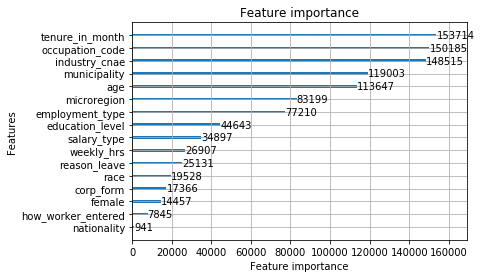

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 6))
lgb.plot_importance(model_lgb)
plt.savefig("feature_importance", dpi = 400)